Задача: сравнить группы по покупкам в проиложении двумя способами: бутстрапом и u-тестом

In [2]:
import numpy as np
import pandas as pd
from scipy.stats import norm, mannwhitneyu
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm

In [3]:
data=pd.read_csv('https://stepik.org/media/attachments/lesson/396008/hw_bootstrap.csv', sep=";")
data.value=data.value.str.replace(",",".").astype('float')

In [4]:
data.head()

Unnamed: 0      value experimentVariant
0           1  10.380495           Control
1           2   9.546867           Control
2           3  11.088215           Control
3           4  10.147274           Control
4           5   9.789808           Control

In [24]:
#Разделим данные на 2 выборки.
control_data=data.query('experimentVariant == "Control"') #Контрольная
test_data = data.query('experimentVariant == "Treatment"') #Тестовая

In [40]:
control_data.value.hist() #Посмотрим на распределения в контрольной и тестовой группах

In [38]:
control_data.describe()

Unnamed: 0       value
count  500.000000  500.000000
mean   250.500000   10.026867
std    144.481833    0.979377
min      1.000000    6.436541
25%    125.750000    9.411024
50%    250.500000   10.018465
75%    375.250000   10.664879
max    500.000000   13.130346

In [39]:
test_data.describe()
#Средние по выборкам сильно отличаются (почти в 3 раза). 
#А так же видно, что в тестовой выборке стандартное отклонение значительно больше стандартного отклонения в Контрольной.

Unnamed: 0        value
count   500.000000   500.000000
mean    750.500000    27.321499
std     144.481833   186.557011
min     501.000000     6.436541
25%     625.750000     9.421968
50%     750.500000    10.025847
75%     875.250000    10.675721
max    1000.000000  3000.000000

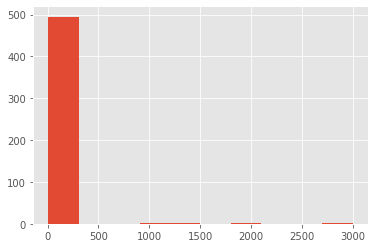

In [41]:
test_data.value.hist() # Такое различие обусловленно тем, что тестовая выборка содержит несколько значительных выбросов.

In [43]:
#Взглянем на медианные значения.
test_data.median()

Unnamed: 0    750.500000
value          10.025847
dtype: float64

In [44]:
control_data.median()

Unnamed: 0    250.500000
value          10.018465
dtype: float64

In [ ]:
#По всей видимости лучше использовать медиану для отображения меры ЦТ, так как сильного отличия, как у средних - нет.

In [30]:
# Объявим функцию, которая позволит проверять гипотезы с помощью бутстрапа
def get_bootstrap(
    data_column_1, # числовые значения первой выборки
    data_column_2, # числовые значения второй выборки
    statistic, # интересующая нас статистика
    boot_it = 1000, # количество бутстрэп-подвыборок
    bootstrap_conf_level = 0.95 # уровень значимости
):
    boot_len = max([len(data_column_1), len(data_column_2)])
    boot_data = []
    for i in tqdm(range(boot_it)): # извлекаем подвыборки
        samples_1 = data_column_1.sample(
            boot_len, 
            replace = True # параметр возвращения
        ).values
        
        samples_2 = data_column_2.sample(
            boot_len, 
            replace = True
        ).values
        
        boot_data.append(statistic(samples_1-samples_2)) # применяем статистику
        
    pd_boot_data = pd.DataFrame(boot_data)
        
    left_quant = (1 - bootstrap_conf_level)/2
    right_quant = 1 - (1 - bootstrap_conf_level) / 2
    ci = pd_boot_data.quantile([left_quant, right_quant])
        
    p_1 = norm.cdf(
        x = 0, 
        loc = np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_2 = norm.cdf(
        x = 0, 
        loc = -np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_value = min(p_1, p_2) * 2
        
    # Визуализация
    plt.hist(pd_boot_data[0], bins = 50)
    
    plt.style.use('ggplot')
    plt.vlines(ci,ymin=0,ymax=50,linestyle='--')
    plt.xlabel('boot_data')
    plt.ylabel('frequency')
    plt.title("Histogram of boot_data")
    plt.show()
       
    return { "ci": ci, 
            "p_value": p_value}

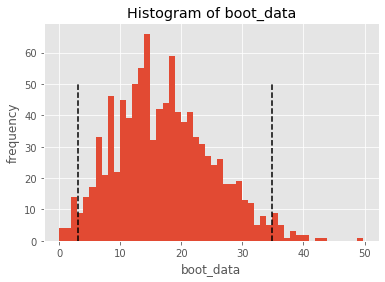

{'ci':                0
 0.025   3.055307
 0.975  34.846415,
 'p_value': 0.031713611901592435}

In [51]:
#Воспользуемся Bootstrap'ом с использованием оценки среднего.
get_bootstrap(
    test_data.value, # числовые значения первой выборки
    control_data.value, # числовые значения второй выборки
    np.mean, # интересующая нас статистика
    boot_it = 1000, # количество бутстрэп-подвыборок
    bootstrap_conf_level = 0.95 # уровень значимости
)

In [ ]:
#P-value< 0.05, а доверительный интервал не включает 0, 
#что говорит о том, что средние в выборках значительно отличаются друг от друга.

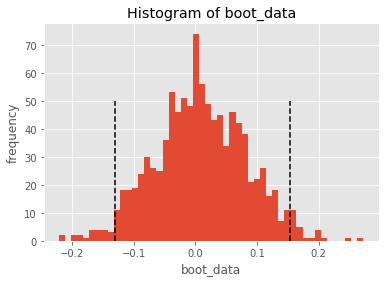

{'ci':               0
 0.025 -0.130515
 0.975  0.153686,
 'p_value': 0.908518361013413}

In [33]:
#Теперь воспользуемся оценкой медиан.
get_bootstrap(
    test_data.value, # числовые значения первой выборки
    control_data.value, # числовые значения второй выборки
    np.median, # интересующая нас статистика
    boot_it = 1000, # количество бутстрэп-подвыборок
    bootstrap_conf_level = 0.95 # уровень значимости
)

In [ ]:
#При таком подходе p-value>0.05, а доверитеьный интервал включаеет 0, что не позволяет отклонить нулевую гипотезу.

In [32]:
mannwhitneyu(test_data.value, control_data.value)

MannwhitneyuResult(statistic=124189.5, pvalue=0.42960742912427896)

In [ ]:
#Критерий Мана-Уитни так же показывает p-value > 0.05, что говорит нам о том, что выборки значимо не отличаются друг от друга.

In [ ]:
#Для оценки представленных данных больше подойдет использование Bootstrap  с оценкой медиан, либо U-критерий.
#Так как из-за больших выбросов в тестовой выборке различие средних в группах сильно выраженно.